### Let's prepare the data for ML algorithm by:

#### 1. Splitting the data in Features and Target
#### 2. Encoding variables
#### 3. Scaling the features using Min-Max Normalization

In [37]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder, MinMaxScaler
from sklearn.impute import SimpleImputer
import category_encoders as ce
from lightgbm import LGBMRegressor

print(pd.__version__)
print(np.__version__)
print(sns.__version__)
print(ce.__version__)
import sklearn
print(sklearn.__version__)

2.3.3
1.26.4
0.13.2
2.8.1
1.7.1


In [38]:
import category_encoders as ce
print(ce.__version__)

2.8.1


In [39]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split



In [40]:
#1. Load the cleaned database
clean_database = pd.read_csv("Cleaned_database.csv")

#2. Split the data in Features and Target
X_features = clean_database.drop('Price', axis=1)
Y = clean_database['Price']

#3. Split data in train and test sets
x_train,x_test,y_train,y_test = train_test_split(X_features,Y,train_size=.8,random_state=42)

print(y_train)


2582     47790
13488    35800
7899     26990
4999     23888
724      12200
         ...  
13418    12995
5390     42990
860      37980
15795    35990
7270     11990
Name: Price, Length: 12718, dtype: int64


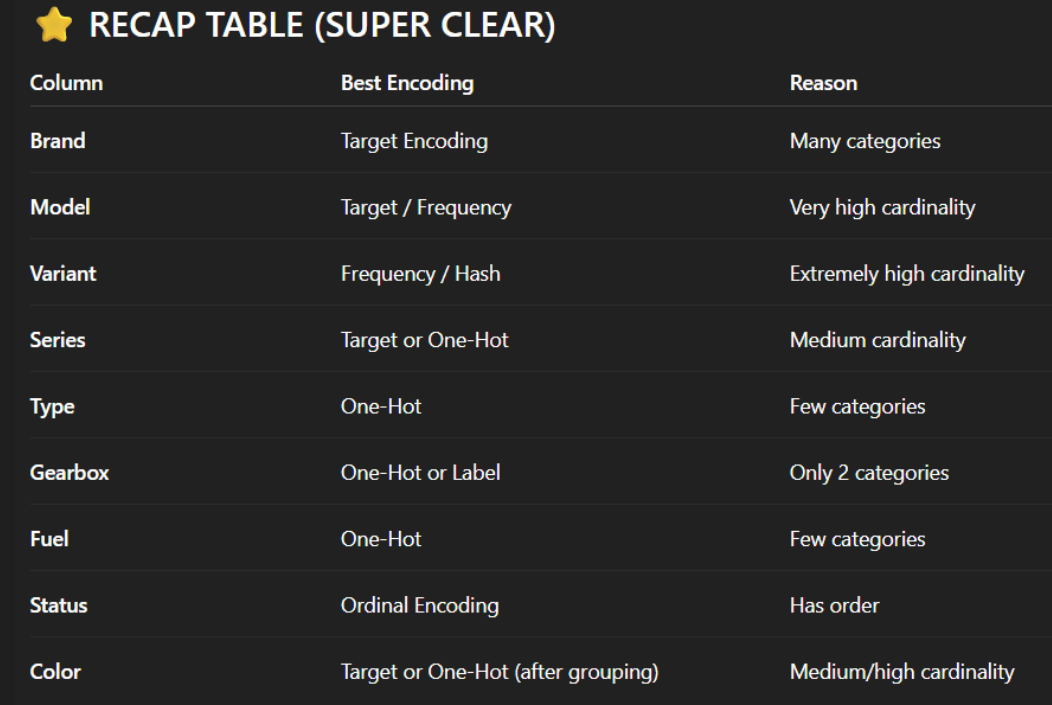

In [41]:
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, MinMaxScaler, OrdinalEncoder
from sklearn.impute import SimpleImputer
import category_encoders as ce 

# 1. Define column groups
cat_ohe_cols = ['Fuel', 'Gearbox'] 
cat_ordinal_cols = ['Status']      
cat_target_cols = ['Brand', 'Model', 'Type', 'Series', 'Color', 'Variant'] 
num_cols = ['Year', 'Kilometers', 'CC', 'Seating Capacity']

# Pipeline for numerical: Impute missing -> Scale
num_pipe = Pipeline([
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', MinMaxScaler())
])

# Pipeline for OneHot: Impute -> Encode
ohe_pipe = Pipeline([
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('encoder', OneHotEncoder(handle_unknown='ignore', drop='first'))
])

# Pipeline for Target Encoding: Impute -> Encode
# TargetEncoder handles new categories in test data automatically
target_pipe = Pipeline([
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('encoder', ce.TargetEncoder()),
    ('scaler',MinMaxScaler()) 
])

# Pipeline for Ordinal Encoding: Impute -> Encode
order = ['New In Stock','Demo','Used']
ordinal_encoder = OrdinalEncoder(categories=[order])
ordinal_pipe = Pipeline([
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('encoder', ordinal_encoder),
    ('scaler',MinMaxScaler())
])

# 3. Combine into a preprocessor
preprocessor = ColumnTransformer(transformers=[
    ('num', num_pipe, num_cols),
    ('ohe', ohe_pipe, cat_ohe_cols),
    ('target', target_pipe, cat_target_cols),
    ('Ordinal', ordinal_pipe, cat_ordinal_cols)
], remainder='drop')

# 4. Apply
# Fit only on TRAIN, transform TRAIN AND TEST

x_train = preprocessor.fit_transform(x_train, y_train)
x_test = preprocessor.transform(x_test)

print("Pipeline complete. Shapes:", x_train.shape, x_test.shape)

feature_names = preprocessor.get_feature_names_out()

Pipeline complete. Shapes: (12718, 18) (3180, 18)


In [27]:
x_train[0]

array([1.00000000e+00, 2.95082935e-05, 8.25373941e-02, 2.50000000e-01,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       1.00000000e+00, 0.00000000e+00, 0.00000000e+00, 4.72143946e-01,
       5.70438587e-01, 5.17023956e-01, 6.08297651e-01, 7.41367932e-01,
       4.52001486e-01, 5.00000000e-01])

In [28]:
print(np.isnan(x_train).sum(axis=0))

[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]


#### Let's make a baseline model based on the mean of the predicted values. I will compare the mean of the train values and the test values and then calculate MAE

In [8]:
#baseline model
from sklearn.metrics import mean_absolute_error

mean_train_data = y_train.mean()
array_mean_model = [mean_train_data]*len(y_test)
mae_baseline = mean_absolute_error(array_mean_model,y_test)
print(f'The Mean Absolute Error of the baseline model is ', mae_baseline)
print(f'The goal is to minimize this value by running a propper model.')

The Mean Absolute Error of the baseline model is  14714.375308456989
The goal is to minimize this value by running a propper model.


## MACHINE LEARNING APPROACH

### Now that our data is ready to be evaluated, let's jump in Machine Learning algorithms. To predict the price of a car, let's run 3 different models:
#### 1. KNN regressor
#### 2. Random Forest Regressor
#### 3. Gradient Boosting (XGBoost)
#### 4. Gradient Boosting (LightGBM)
##### Then, evaluate those models and pick the best one based on the results.

#### 1. KNN regressor

In [9]:
# 1. KNN Regressor model
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import GridSearchCV


KNN = KNeighborsClassifier(n_neighbors = 4)
KNN.fit(x_train,y_train)

y_pred_KNN = KNN.predict(x_test)

mae = mean_absolute_error(y_test, y_pred_KNN)
rmse = np.sqrt(mean_squared_error(y_test, y_pred_KNN))
r2 = r2_score(y_test, y_pred_KNN)
print("KNN Results:")

print(f"MAE:  {mae:.2f}")
print(f"RMSE: {rmse:.2f}")
print(f"R²:   {r2:.4f}")

results = {
    'KNN' : {'Mean Absolute Error' : mae, 'Root Mean Square Error' : rmse, 'R2':r2}
}


KNN Results:
MAE:  5579.27
RMSE: 8369.96
R²:   0.7894


##### Tunning the model...

In [10]:
#Tunning Hyperparameter K
k_range = list(range(3,10))
param_grid = dict(n_neighbors=k_range)

KNN = KNeighborsClassifier()
grid = GridSearchCV(estimator=KNN, param_grid=param_grid, cv=10, scoring='accuracy')
grid.fit(x_train,y_train)
best_k = grid.best_params_['n_neighbors']
best_score = grid.best_score_
print(f"Cross-Validated Accuracy with K={best_k}: {best_score:.4f}")
final_knn_model = grid.best_estimator_
y_pred_KNN = final_knn_model.predict(x_test)


mae = mean_absolute_error(y_test, y_pred_KNN)
rmse = np.sqrt(mean_squared_error(y_test, y_pred_KNN))
r2 = r2_score(y_test, y_pred_KNN)
print("KNN Results:")

print(f"MAE:  {mae:.2f}")
print(f"RMSE: {rmse:.2f}")
print(f"R²:   {r2:.4f}")

results = {
    'KNN' : {'Mean Absolute Error' : mae, 'Root Mean Square Error' : rmse, 'R2':r2}
}

c:\Users\pipec\anaconda3\envs\ml\lib\site-packages\sklearn\model_selection\_split.py:811: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=10.
  warnings.warn(
c:\Users\pipec\anaconda3\envs\ml\lib\site-packages\sklearn\metrics\_classification.py:98: UserWarning: The number of unique classes is greater than 50% of the number of samples. `y` could represent a regression problem, not a classification problem.
  type_true = type_of_target(y_true, input_name="y_true")
c:\Users\pipec\anaconda3\envs\ml\lib\site-packages\sklearn\metrics\_classification.py:98: UserWarning: The number of unique classes is greater than 50% of the number of samples. `y` could represent a regression problem, not a classification problem.
  type_true = type_of_target(y_true, input_name="y_true")
c:\Users\pipec\anaconda3\envs\ml\lib\site-packages\sklearn\metrics\_classification.py:98: UserWarning: The number of unique classes is greater than 50% of the number of samples. `y`

Cross-Validated Accuracy with K=3: 0.0269
KNN Results:
MAE:  5086.20
RMSE: 7696.25
R²:   0.8219


#### 2. Random Forest Regressor

In [11]:
# 2. Random Forest Regressor
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import RandomizedSearchCV

RF = RandomForestRegressor(random_state=42)
RF.fit(x_train,y_train)
y_pred_RF = RF.predict(x_test)

rf_mae = mean_absolute_error(y_test, y_pred_RF)
rf_rmse = np.sqrt(mean_squared_error(y_test, y_pred_RF))
rf_r2 = r2_score(y_test, y_pred_RF)

print("Random Forest Results:")
print(f"MAE:  {rf_mae:.2f}")
print(f"RMSE: {rf_rmse:.2f}")
print(f"R²:   {rf_r2:.4f}")


results = {
    'KNN' : {'Mean Absolute Error' : mae, 'Root Mean Square Error' : rmse, 'R2':r2},
    'Random Forest Regressor' : {'Mean Absolute Error' : rf_mae, 'Root Mean Square Error' : rf_rmse, 'R2':rf_r2}
    
    }

Random Forest Results:
MAE:  3836.66
RMSE: 6208.71
R²:   0.8841


#### Tunning the model...

In [12]:


param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['sqrt', 'log2'],
    'bootstrap': [True, False]
}
RF = RandomForestRegressor(random_state=42)

#Tunning hyperparameters
search = RandomizedSearchCV(
    RF,
    param_grid,
    n_iter=20,           
    scoring='neg_mean_absolute_error',
    cv=4,
    random_state=42,
    n_jobs=1
)
search.fit(x_train,y_train)
best_rf = search.best_estimator_
y_pred_RF = best_rf.predict(x_test)

rf_mae = mean_absolute_error(y_test, y_pred_RF)
rf_rmse = np.sqrt(mean_squared_error(y_test, y_pred_RF))
rf_r2 = r2_score(y_test, y_pred_RF)

print("Random Forest Results:")
print(f"MAE:  {rf_mae:.2f}")
print(f"RMSE: {rf_rmse:.2f}")
print(f"R²:   {rf_r2:.4f}")


results = {
    'KNN' : {'Mean Absolute Error' : mae, 'Root Mean Square Error' : rmse, 'R2':r2},
    'Random Forest Regressor' : {'Mean Absolute Error' : rf_mae, 'Root Mean Square Error' : rf_rmse, 'R2':rf_r2}
    
    }

Random Forest Results:
MAE:  3498.20
RMSE: 5651.16
R²:   0.9040


In [44]:
importances = pd.Series(best_rf.feature_importances_, index=feature_names)
importances.sort_values(ascending=False)

target__3                              0.264406
target__5                              0.246682
num__Year                              0.146147
target__1                              0.100719
num__Kilometers                        0.095056
num__CC                                0.040605
target__0                              0.030391
ohe__Fuel_Unleaded Petrol              0.027930
target__2                              0.025560
num__Seating Capacity                  0.005764
target__4                              0.005285
ohe__Fuel_Premium Unleaded Petrol      0.004168
Ordinal__Status                        0.003055
ohe__Gearbox_Manual                    0.003001
ohe__Fuel_Unleaded Petrol/Electric     0.000616
ohe__Fuel_Premium Unleaded/Electric    0.000574
ohe__Fuel_Liquid Petroleum Gas         0.000039
ohe__Fuel_Diesel/Electric              0.000005
dtype: float64

#### 3. Gradient Boosting (XGBoost)

In [14]:
# 3. Gradient Boosting (XGBoost)
from sklearn.ensemble import GradientBoostingRegressor

gbr = GradientBoostingRegressor()


gbr.fit(x_train,y_train)

y_pred_GBR = gbr.predict(x_test)

gbr_mae = mean_absolute_error(y_test, y_pred_GBR)
gbr_rmse = np.sqrt(mean_squared_error(y_test, y_pred_GBR))
gbr_r2 = r2_score(y_test, y_pred_GBR)

print("Gradient Boosting Results:")
print(f"MAE:  {gbr_mae:.2f}")
print(f"RMSE: {gbr_rmse:.2f}")
print(f"R²:   {gbr_r2:.4f}")

results = {
    'KNN' : {'Mean Absolute Error' : mae, 'Root Mean Square Error' : rmse, 'R2':r2},
    'Random Forest Regressor' : {'Mean Absolute Error' : rf_mae, 'Root Mean Square Error' : rf_rmse, 'R2':rf_r2},
    'Gradient Boosting' : {'Mean Absolute Error' : gbr_mae, 'Root Mean Square Error' : gbr_rmse, 'R2':gbr_r2}
    }

Gradient Boosting Results:
MAE:  4483.39
RMSE: 6611.33
R²:   0.8686


#### Tunning the model...

In [15]:
# 3. Gradient Boosting (XGBoost)
from sklearn.ensemble import GradientBoostingRegressor

gbr = GradientBoostingRegressor()

param_grid = {
    'n_estimators': [100, 200, 300],
    'learning_rate': [0.01,0.1,0.2],
    'max_depth': [3,4,5],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'criterion': ['friedman_mse']
}

gbr_cv= GridSearchCV(
    gbr, 
    param_grid, 
    cv = 3,
    n_jobs=-1,
    scoring = 'neg_mean_squared_error'
    )


gbr_cv.fit(x_train,y_train)

y_pred_GBR = gbr_cv.predict(x_test)

gbr_mae = mean_absolute_error(y_test, y_pred_GBR)
gbr_rmse = np.sqrt(mean_squared_error(y_test, y_pred_GBR))
gbr_r2 = r2_score(y_test, y_pred_GBR)

print("Gradient Boosting Results:")
print(f"MAE:  {gbr_mae:.2f}")
print(f"RMSE: {gbr_rmse:.2f}")
print(f"R²:   {gbr_r2:.4f}")

results = {
    'KNN' : {'Mean Absolute Error' : mae, 'Root Mean Square Error' : rmse, 'R2':r2},
    'Random Forest Regressor' : {'Mean Absolute Error' : rf_mae, 'Root Mean Square Error' : rf_rmse, 'R2':rf_r2},
    'Gradient Boosting' : {'Mean Absolute Error' : gbr_mae, 'Root Mean Square Error' : gbr_rmse, 'R2':gbr_r2}
    }

Gradient Boosting Results:
MAE:  3377.37
RMSE: 5300.77
R²:   0.9155


In [45]:
best_xgb = gbr_cv.best_estimator_
importances = pd.Series(best_xgb.feature_importances_, index=feature_names)
importances.sort_values(ascending=False).head(20)

target__3                              0.632650
target__5                              0.177836
num__Kilometers                        0.052876
num__Year                              0.040459
num__CC                                0.034145
target__1                              0.029552
target__0                              0.015944
target__2                              0.004864
ohe__Fuel_Unleaded Petrol              0.004209
ohe__Fuel_Premium Unleaded Petrol      0.002003
num__Seating Capacity                  0.001931
target__4                              0.001610
ohe__Gearbox_Manual                    0.001214
ohe__Fuel_Premium Unleaded/Electric    0.000478
Ordinal__Status                        0.000138
ohe__Fuel_Unleaded Petrol/Electric     0.000057
ohe__Fuel_Liquid Petroleum Gas         0.000033
ohe__Fuel_Diesel/Electric              0.000000
dtype: float64

#### 4. LightGBM 

In [17]:
from lightgbm import LGBMRegressor

lightgbm = LGBMRegressor(random_state=42)
lightgbm.fit(x_train,y_train)
y_pred = lightgbm.predict(x_test)

mae_light = mean_absolute_error(y_test, y_pred)
rmse_light = np.sqrt(mean_squared_error(y_test, y_pred))
r2_light = r2_score(y_test, y_pred)

print("MAE:", mae_light)
print("RMSE:", rmse_light)
print("R2:", r2_light)


[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001534 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1376
[LightGBM] [Info] Number of data points in the train set: 12718, number of used features: 17
[LightGBM] [Info] Start training from score 32803.568328
MAE: 3722.349030063767
RMSE: 5752.60561056651
R2: 0.900522124133224


c:\Users\pipec\anaconda3\envs\ml\lib\site-packages\sklearn\utils\deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\pipec\anaconda3\envs\ml\lib\site-packages\sklearn\utils\deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


#### Tunning the model...

In [18]:
from lightgbm import LGBMRegressor

lightgbm = LGBMRegressor(random_state=42)

param_dist = {
    'n_estimators': [100, 200, 300],
    'learning_rate': [0.05, 0.1, 0.2],
    'max_depth': [-1, 4, 5],
    'subsample': [0.7, 0.8, 1.0],
    'colsample_bytree': [0.7, 0.8, 1.0],
    'num_leaves': [15, 31, 63]    
}

# Tunning Hyperparameters
tuner = RandomizedSearchCV(
    estimator=lightgbm,
    param_distributions=param_dist,
    n_iter=20,                 
    scoring='neg_mean_absolute_error',  
    cv=3,                      
    verbose=1,
    n_jobs=-1,
    random_state=42
)

tuner.fit(x_train,y_train)
best_model_lgb = tuner.best_estimator_
print("Best parameters:", tuner.best_params_)

y_pred = best_model_lgb.predict(x_test)

mae_light = mean_absolute_error(y_test, y_pred)
rmse_light = np.sqrt(mean_squared_error(y_test, y_pred))
r2_light = r2_score(y_test, y_pred)

print("MAE:", mae_light)
print("RMSE:", rmse_light)
print("R2:", r2_light)



Fitting 3 folds for each of 20 candidates, totalling 60 fits


c:\Users\pipec\anaconda3\envs\ml\lib\site-packages\sklearn\utils\deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001188 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1376
[LightGBM] [Info] Number of data points in the train set: 12718, number of used features: 17
[LightGBM] [Info] Start training from score 32803.568328
Best parameters: {'subsample': 1.0, 'num_leaves': 31, 'n_estimators': 300, 'max_depth': -1, 'learning_rate': 0.05, 'colsample_bytree': 0.8}
MAE: 3586.1973271871025
RMSE: 5540.360562646465
R2: 0.9077272719609588


c:\Users\pipec\anaconda3\envs\ml\lib\site-packages\sklearn\utils\deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


In [46]:

results = {
    'KNN' : {'Mean Absolute Error' : mae, 'Root Mean Square Error' : rmse, 'R2':r2},
    'Random Forest Regressor' : {'Mean Absolute Error' : rf_mae, 'Root Mean Square Error' : rf_rmse, 'R2':rf_r2},
    'Gradient Boosting (XGBoost)' : {'Mean Absolute Error' : gbr_mae, 'Root Mean Square Error' : gbr_rmse, 'R2':gbr_r2},
    'LightGBM' : {'Mean Absolute Error' : mae_light, 'Root Mean Square Error' : rmse_light, 'R2':r2_light}
    }

importances = pd.Series(best_model_lgb.feature_importances_, index=feature_names)
importances.sort_values(ascending=False).head(20)

target__5                              1612
target__3                              1212
num__CC                                1157
num__Kilometers                        1149
target__1                              1126
target__0                               797
num__Year                               648
target__2                               416
target__4                               241
num__Seating Capacity                   226
ohe__Fuel_Unleaded Petrol               152
ohe__Gearbox_Manual                     108
ohe__Fuel_Premium Unleaded Petrol       100
ohe__Fuel_Liquid Petroleum Gas           19
Ordinal__Status                          15
ohe__Fuel_Unleaded Petrol/Electric       13
ohe__Fuel_Premium Unleaded/Electric       9
ohe__Fuel_Diesel/Electric                 0
dtype: int32

In [47]:
results

{'KNN': {'Mean Absolute Error': 5086.204402515723,
  'Root Mean Square Error': 7696.2456452529805,
  'R2': 0.8219446021922141},
 'Random Forest Regressor': {'Mean Absolute Error': 3498.1984885459483,
  'Root Mean Square Error': 5651.155452574713,
  'R2': 0.9039998723705469},
 'Gradient Boosting (XGBoost)': {'Mean Absolute Error': 3377.3740514309893,
  'Root Mean Square Error': 5300.766403587591,
  'R2': 0.9155354185725922},
 'LightGBM': {'Mean Absolute Error': 3586.1973271871025,
  'Root Mean Square Error': 5540.360562646465,
  'R2': 0.9077272719609588}}

#### Conclusion: After careful review of the results (Errors and R square), The best model to work with is Gradient Boosting (XGBoost)

#### Let's retrain the model, this time doing feature selection

In [ ]:
# 1. Define column groups
cat_ohe_cols = ['Fuel', 'Gearbox'] 
cat_ordinal_cols = ['Status']      
cat_target_cols = ['Brand', 'Model', 'Type', 'Series', 'Color', 'Variant'] 
num_cols = ['Year', 'Kilometers', 'CC', 'Seating Capacity']